In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, sys, shutil
warnings.filterwarnings("ignore")

In [114]:
train = pd.read_csv('./icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('./icr-identify-age-related-conditions/test.csv')
meta = pd.read_csv('./icr-identify-age-related-conditions/greeks.csv')
# train.describe()

In [115]:
train_init = train.copy()
train['Alpha'] = meta['Alpha'].copy()
train['Beta'] = meta['Beta']
train['Gamma'] = meta['Gamma']
train['Delta'] = meta['Delta']

**需要注意，能够下载的测试集并不完整，可能会出现训练集中没有的类别，对测试集的处理需要小心一点，否则会提交错误导致1 miss**

In [116]:
# 处理greeks
# Alpha为A的时候为0，其余为1
train['Alpha'] = train['Alpha'].apply(lambda x: 0 if x == 'A' else 1)
train.head(10)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,72.611063,2003.810319,22.136229,69.834944,0.120343,1,1,C,G,D
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,72.611063,27981.562750,29.135430,32.131996,21.978000,0,0,C,M,B
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0,C,M,B
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0,C,M,B
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,146.109943,8524.370502,45.381316,36.262628,0.096614,1,1,B,F,B
5,04517a3c90bd,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,...,72.611063,24177.595550,28.525186,82.527764,21.978000,0,0,C,M,B
6,049232ca8356,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,...,192.453107,3332.467494,34.166222,100.086808,0.065096,0,0,C,M,B
7,057287f2da6d,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,...,109.693986,21371.759850,35.208102,31.424696,0.092873,0,0,C,M,B
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,147.218610,4589.611956,29.771721,54.675576,0.073416,0,0,C,M,B
9,05f2bc0155cd,0.324748,5188.68207,85.200147,12.968687,8.138688,4.593392,0.025578,10.685041,1.229900,...,98.929757,5563.130949,21.994831,33.300970,21.978000,0,0,B,M,B


In [117]:
# 将数据集中唯一的离散特征转为01，这可能表明患者的性别
train['EJ'] = train['EJ'].replace({'A': 0, 'B': 1}).astype(float)
test['EJ']  = test['EJ'].replace({'A': 0, 'B': 1}).astype(float)
train_init['EJ'] = train_init['EJ'].replace({'A': 0, 'B': 1}).astype(float)
# 缺失值处理，用中位数填充
train['BQ'].fillna(0, inplace=True)
train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)
train_init.fillna(train_init.median(), inplace=True)
# 移除ID列
train_id = train['Id'].copy()
test_id  =  test['Id'].copy()
train = train.drop(['Id'], axis=1)
test  =  test.drop(['Id'], axis=1)
# train_id = train.drop(['Id'], axis=1, inplace=True)
# test_id  =  test.drop(['Id'], axis=1, inplace=True)
train_init_id = train_init.drop(['Id'], axis=1, inplace=True)
# 将离散变量分离出来
train_discrete = train[['EJ', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Class']]
# 将连续变量分离出来
train_continuous = train.drop(['EJ', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Class'], axis=1)

train.isnull().sum()

AB       0
AF       0
AH       0
AM       0
AR       0
        ..
Class    0
Alpha    0
Beta     0
Gamma    0
Delta    0
Length: 61, dtype: int64

In [118]:
# test_id.head(10)

In [119]:
# 由于我们需要预测Alpha，Beta，Gamma和Delta以及class，通过可视化来判断这些特征与class之间的关系

def plot_distribution(data, target_col):
    # 将目标列加入到最后一列
    data_c = data.copy()
    data_c[target_col] = train_discrete[target_col]
    num_cols = 4
    num_rows = len(data_c.columns)
    fig, axes = plt.subplots(nrows=num_rows//4, ncols=num_cols, figsize=(20, num_rows))
    sns.set(font_scale=1.2, style='whitegrid')
    for i, col_name in enumerate(data_c.columns):
        if col_name != target_col:
            ax = axes[i // num_cols, i % num_cols]
            sns.kdeplot(data=data_c, x=data_c[col_name], hue=data_c[target_col], ax=ax, fill=True)
            ax.set_xlabel(col_name.title(), fontsize=14)
            ax.set_ylabel(target_col.title(), fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=12)
            # ax.legend([1, 0], title=target_col.title(), fontsize=12)
    plt.tight_layout()
    plt.show()

In [120]:
# plot_distribution(train_continuous, "Beta")

In [121]:
# plot_distribution(train_continuous, "Gamma")

In [122]:
# plot_distribution(train_continuous, "Delta")

In [123]:
# plot_distribution(train_continuous, "Class")

<AxesSubplot:xlabel='Delta', ylabel='Alpha'>

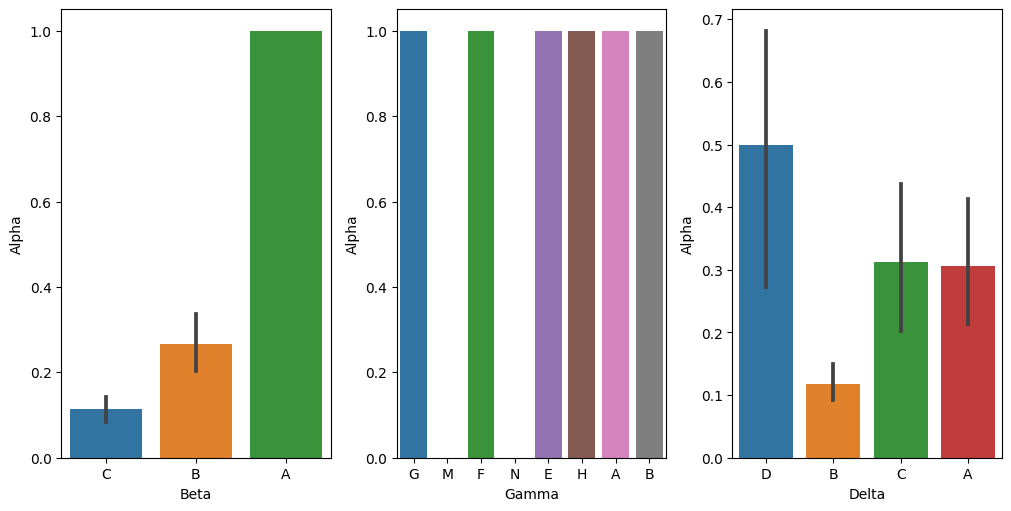

In [124]:
# 现在观察Beta，Gamma和Delta与Alpha之间的关系，我们需要预测Class，即为预测Alpha

fig, ax =plt.subplots(1,3,constrained_layout=True, figsize=(10, 5))
sns.barplot(x='Beta', y='Alpha', data=train_discrete, ax=ax[0])
sns.barplot(x='Gamma', y='Alpha', data=train_discrete, ax=ax[1])
sns.barplot(x='Delta', y='Alpha', data=train_discrete, ax=ax[2])

*注意，值越低，说明没有患病*
通过该图可以发现，gamma值为MN一定不会患病，Beta为C且Delta为B患病概率也较低
之后的预测策略是，先预测beta，gamma和delta的值，再通过三者的值来预测alpha的值
*额外注意应该将MN看为一类，GFEHAB看为一类，他们的分布都过于相近*

In [125]:
# 箱线图，观察离群点
# 本来是准备处理异常值的，但是通过discussion发现，这些异常值处理后模型并不会得到什么提升，所以就不处理了
# 而且个人认为这些异常值可能会决定患者的症状，所以保留

In [126]:
# 热力图，观察特征之间的相关性，删除相关性较强的特征
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(40, 40))

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=18)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 7, "weight": "bold"},
                mask=mask)

# plot_heatmap(train_init, title='Data')

In [127]:
# 层次聚类

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def hierarchical_clustering(data):
    fig, ax = plt.subplots(1, 1, figsize=(18, 10), dpi=120)
    correlations = data.corr()
    converted_corr = 1 - np.abs(correlations)
    Z = linkage(squareform(converted_corr), 'complete')
    
    dn = dendrogram(Z, labels=data.columns, ax=ax, above_threshold_color='#ff0000', orientation='right')
    hierarchy.set_link_color_palette(None)
    plt.grid(axis='x')
    plt.title('Hierarchical clustering, Dendrogram', fontsize=18, fontweight='bold')
    plt.show()

# hierarchical_clustering(train_init.drop('Class', axis=1))

准备先通过删除部分相似度高的数据，如果后期效果不行的话，就用PCA降维了

In [128]:
train.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,72.611063,2003.810319,22.136229,69.834944,0.120343,1,1,C,G,D
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,72.611063,27981.562750,29.135430,32.131996,21.978000,0,0,C,M,B
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0,C,M,B
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0,C,M,B
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,146.109943,8524.370502,45.381316,36.262628,0.096614,1,1,B,F,B


In [129]:
# 特征处理
# 将gamma中的M和N都转为0，G，H，E，F，A，B的转为1
train['Gamma'] = train['Gamma'].replace({'M': 0, 'N': 0, 'G': 1, 'H': 1, 'E': 1, 'F': 1, 'A': 1, 'B': 1})
# train['Gamma'] = train['Gamma'].replace({'M': 0, 'N': 1, 'G': 2, 'H': 3, 'E': 4, 'F': 5, 'A': 6, 'B': 7})
# 将Beta中的C0,B1,A2
# train['Beta'] = train['Beta'].replace({'C': 0, 'B': 1, 'A': 2})
train['Beta'] = train['Beta'].replace({'C': 0, 'B': 1, 'A': 1})
# 将Delta中的B0,A1,C1,D2
# train['Delta'] = train['Delta'].replace({'B': 0, 'A': 1, 'C': 1, 'D': 2})
# train['Delta'] = train['Delta'].replace({'B': 0, 'A': 1, 'C': 1, 'D': 1})
train['Delta'] = train['Delta'].replace({'B': 0, 'A': 1, 'C': 2, 'D': 3})

train.head()


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,72.611063,2003.810319,22.136229,69.834944,0.120343,1,1,0,1,3
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,72.611063,27981.562750,29.135430,32.131996,21.978000,0,0,0,0,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0,0,0,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0,0,0,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,146.109943,8524.370502,45.381316,36.262628,0.096614,1,1,1,1,0


In [130]:
# 连续变量归一化处理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_columns = [_ for _ in train.columns if _ not in ['EJ', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Class']]
train[numeric_columns] = scaler.fit_transform(train[numeric_columns])
test[numeric_columns] = scaler.transform(test[numeric_columns])
train.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta
0,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,-0.405383,...,-0.410260,-0.655511,-0.948991,0.531241,-0.814049,1,1,0,1,3
1,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,0.048541,...,-0.410260,0.687893,-0.238862,-0.509218,1.304860,0,0,0,0,0
2,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,-0.071089,...,-0.299210,-0.051850,-0.351743,-0.424754,-0.806623,0,0,0,0,0
3,-0.480851,0.138196,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,-0.391109,...,-0.342195,-0.650833,0.858232,1.101332,-0.810609,0,0,0,0,0
4,-0.206946,0.100517,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,0.125327,...,0.099920,-0.318309,1.409422,-0.395228,-0.816349,1,1,1,1,0


In [131]:
# 抛弃高度相关的特征
drop_cols = ['BZ','CL','EH','GL']  # 高度相关
drop_cols2 = ['DY','CB','GB','CH','DL','CU','FS','AZ','GE','EG','EP']  # 无用特征，同一点取得极值
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

In [132]:
# ytrain为离散
ytrain = train[['Class', 'Alpha', 'Beta', 'Gamma', 'Delta']]
train.drop(['Class', 'Alpha', 'Beta', 'Gamma', 'Delta'], axis=1, inplace=True)
# scale_pos_weight = len(class_train[class_train == 0]) / len(class_train[class_train == 1])
# scale_pos_weight 4.712962962962963

In [133]:
train.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI
0,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,-0.405383,...,-0.112922,-2.226608,0.162821,-0.035806,-0.250437,-0.940094,-0.410260,-0.655511,-0.948991,0.531241
1,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,0.048541,...,-0.311056,0.084542,-0.457925,-0.060566,0.113640,-1.145070,-0.410260,0.687893,-0.238862,-0.509218
2,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,-0.071089,...,-0.173811,0.517060,0.198663,-0.051023,0.597343,1.637944,-0.299210,-0.051850,-0.351743,-0.424754
3,-0.480851,0.138196,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,-0.391109,...,0.058201,1.617160,0.060364,-0.060566,-0.104806,-0.219883,-0.342195,-0.650833,0.858232,1.101332
4,-0.206946,0.100517,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,0.125327,...,0.520331,1.212850,0.237302,0.896815,-0.229632,-0.432313,0.099920,-0.318309,1.409422,-0.395228


# 模型搭建
先直接对Class预测

In [134]:
# 数据集分割
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
X = ytrain[['Beta', 'Delta']].copy()

# x转为独热码
# X = pd.get_dummies(X, columns=['Beta', 'Delta'])
# Y = ytrain['Class'].copy()
x_train, x_test, y_train, y_test = train_test_split(X, ytrain, test_size=0.2, random_state=42)
scale_pos_weight = 4.712962962962963
print(x_train.shape)
print(y_train.shape)

(493, 2)
(493, 5)


In [135]:
x_test.head(100).T

,49,581,82,304,109,605,268,352,327,439,...,212,543,321,289,390,329,451,155,81,250
Beta,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,1,1,0,0,1,0
Delta,0,0,0,0,0,1,2,0,2,3,...,2,2,0,0,0,0,0,0,0,0


In [136]:
def ScoreMetric(ytrue, ypred):
    nc = np.bincount(ytrue);
    return log_loss(ytrue, ypred, sample_weight = 1 / nc[ytrue], eps=1e-15);

In [137]:
# 线性
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.1, solver='liblinear', max_iter=1000)
lr.fit(x_train, y_train['Class'])
y_pred = lr.predict(x_test)
print('lr:', accuracy_score(y_test['Class'], y_pred))


lr: 0.8145161290322581


In [138]:
import xgboost as xgb

xgb_c = xgb.XGBClassifier(n_estimators=300, learning_rate=0.01, max_depth=4, random_state=42)
xgb_c.fit(x_train, y_train['Class'])
xgb_pred = xgb_c.predict(x_test)
y_pred = xgb_c.predict_proba(x_test)
xgb_accuracy = accuracy_score(xgb_pred, y_test['Class'])
# xgb_pred
xgb_accuracy

0.8145161290322581

In [139]:
Params1 = {
        'booster': 'gbtree',
        'lambda': 5.007638479414757e-05,
        'alpha': 1.0601341392077246e-08,
        'subsample': 0.7996174631849311,
        'colsample_bytree': 0.7148589786704331,
        'max_depth': 12,
        'eta': 0.13341517481633328,
        'gamma': 0.024208002338502885,
        'grow_policy': 'lossguide'
}
Params2 = {
        'booster': 'gbtree',
        'lambda': 0.24302130237467398,
        'alpha': 2.2108795894332237e-08,
        'subsample': 0.7887998109844777,
        'colsample_bytree': 0.4493748858737539,
        'max_depth': 2,
        'eta': 0.29846902305256606,
        'gamma': 1.4539411503015061e-05,
        'grow_policy': 'lossguide'
}
xgb_b = xgb.XGBClassifier(**Params2)
xgb_b.fit(x_train, y_train['Class'])
xgb_pred = xgb_b.predict(x_test)
y_pred = xgb_b.predict_proba(x_test)
xgb_accuracy = accuracy_score(xgb_pred, y_test['Class'])

xgb_accuracy

0.8145161290322581

In [140]:
# lightgbm
import lightgbm as lgb
param_lgb = {
#  'early_stopping_rounds': 116,
 'n_estimators': 8594,
 'learning_rate': 0.2292825799916429,
 'num_leaves': 190,
 'max_depth': 3,
 'reg_alpha': 0.3086813444028655,
 'reg_lambda': 0.08439961817618014,
 'bagging_fraction': 1.0,
 'bagging_freq': 1,
 'feature_fraction': 1.0,
 'min_child_samples': 75,
 'colsample_bytree': 0.2572293361418775,
 'lambda_l1': 1.246275770846192e-06,
 'lambda_l2': 0.011660417895786973,
 'subsample': 0.7301110313724658
 } # 0.18
lgb_c = lgb.LGBMClassifier(**param_lgb)
lgb_c.fit(x_train, y_train['Class'])
lgb_pred = lgb_c.predict(x_test)
y_pred = lgb_c.predict_proba(x_test)
lgb_accuracy = accuracy_score(lgb_pred, y_test['Class'])
lgb_accuracy

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.2572293361418775 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1.246275770846192e-06, reg_alpha=0.3086813444028655 will be ignored. Current value: lambda_l1=1.246275770846192e-06
[LightGBM] [Warning] lambda_l2 is set=0.011660417895786973, reg_lambda=0.08439961817618014 will be ignored. Current value: lambda_l2=0.011660417895786973
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7301110313724658 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.2572293361418775 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1.246275770846192e-06, reg_alpha=0.3086813444028655 will be ignored. Current value: lambda_l1=1.246275770846192e-06
[LightGBM] [Warning]

0.8145161290322581

In [141]:
p0 = y_pred[:,1]
# p0[p0 > 0.9] = 0.99
# p0[p0 < 0.1] = 0.01
# odds = 4.71 * p0 / (1-p0)
# p0 = odds / (1+odds)
ScoreMetric(y_test['Class'], p0)

0.8491252094641172

In [142]:
y_pred = xgb_b.predict_proba(test)
p0 = y_pred[:,0]
# p0[p0 > 0.8] = 0.99
# p0[p0 < 0.2] = 0.01
odds = 4.71 * p0 / (1-p0)
p0 = odds / (1+odds)
submission = pd.DataFrame(test_id, columns=["Id"])
submission["class_0"] = p0
submission["class_1"] = 1 - p0
submission.to_csv('./icr-identify-age-related-conditions/submission.csv', index=False)
submission_df = pd.read_csv('./icr-identify-age-related-conditions/submission.csv')
submission_df


ValueError: Feature shape mismatch, expected: 2, got 52

# 正式的KFold交叉验证 + Optuna模型调参